In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
user_df=pd.read_csv('takehome_users.csv', encoding='latin-1')
eng_df=pd.read_csv('takehome_user_engagement.csv')
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


First of all, let's convert our 'time_stamp' column into datetime object.

In [4]:
eng_df['time_stamp']=pd.to_datetime(eng_df['time_stamp'])

Now let's create a function that'll help us identify adopted users and apply the function to our user data.

In [5]:
def adopted_user(user_id):
    user_data = eng_df[eng_df['user_id'] == user_id]
    if user_data.shape[0]<3:
        return 0
    else:
        user_data = user_data.sort_values('time_stamp')
        user_data['date'] = user_data['time_stamp'].dt.date
        user_data['diff'] = user_data['date'].diff().dt.days
        user_data['rolling_sum'] = user_data['diff'].rolling(window=2).sum()
        if any(user_data['rolling_sum'] <= 7):
            return 1
        else:
            return 0

In [6]:
user_df['adopted']=user_df['object_id'].apply(adopted_user)
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Now let's do some data cleaning

In [7]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


We have a lot of missing values in 'last_session_creation_time' and 'invited_by_user_id' columns. For the former first we need to convert Epoch to datetime. And for the missing values we can impute them with the creation time. </br>
For the 'invited_by_user_id' we assume that those are the rows that were not invited by anybody, so we'll impute those values with 0 since we don't have a user with that id.

In [8]:
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'], unit='s')
user_df['last_session_creation_time'].fillna(value=user_df['creation_time'], inplace=True)

user_df['invited_by_user_id'].fillna(0, inplace=True)

Now let's check for duplicate rows

In [9]:
user_df.duplicated().sum()

0

Let's do some exploratory analysis and try to understand the relationships between the features.

In [10]:
user_df['adopted'].value_counts(normalize=True)

0    0.862
1    0.138
Name: adopted, dtype: float64

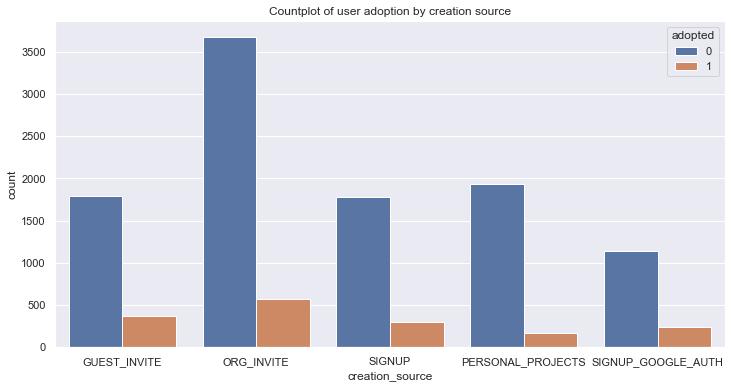

In [11]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(data=user_df, x='creation_source', hue='adopted').set(title='Countplot of user adoption by creation source')
plt.show()

In [12]:
user_df.groupby('creation_source')['adopted'].value_counts(normalize=True)

creation_source     adopted
GUEST_INVITE        0          0.829404
                    1          0.170596
ORG_INVITE          0          0.865068
                    1          0.134932
PERSONAL_PROJECTS   0          0.918522
                    1          0.081478
SIGNUP              0          0.855295
                    1          0.144705
SIGNUP_GOOGLE_AUTH  0          0.827437
                    1          0.172563
Name: adopted, dtype: float64

Only 14 % of users are adopted and if we take a look at  that rate for different creation sources, we can notice relatively higher percent of user adoption for guest invite (those users have limited  permissions) and  those who signed up using Google Authentication.

Before building our model let's create a new column:'invited_bool' showing whether the person was invited by somebody or not.

In [14]:
user_df['diff_days']=(user_df['last_session_creation_time']-user_df['creation_time']).dt.days
user_df['invited_bool']=0
user_df.loc[user_df['invited_by_user_id']>0, 'invited_bool']=1

Now let's build our model, we'll use logistic refression for this data.

In [15]:
X=user_df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'diff_days', 'invited_bool']]
y=user_df['adopted']

X = pd.get_dummies(data = X, columns = ['creation_source'])

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X=pd.DataFrame(scaled_X, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [16]:
log_reg=LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred=log_reg.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Model Accuracy: ', accuracy)

Model Accuracy:  0.9691666666666666


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2073
           1       0.98      0.79      0.87       327

    accuracy                           0.97      2400
   macro avg       0.97      0.89      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [22]:
feature_importance=log_reg.coef_[0]

for feature_name, coef in zip(scaled_X.columns, feature_importance):
    print(f'{feature_name}: {round(coef, 2)}')

opted_in_to_mailing_list: 0.07
enabled_for_marketing_drip: -0.03
diff_days: 23.41
invited_bool: 0.1
creation_source_GUEST_INVITE: 0.13
creation_source_ORG_INVITE: -0.03
creation_source_PERSONAL_PROJECTS: -0.44
creation_source_SIGNUP: 0.13
creation_source_SIGNUP_GOOGLE_AUTH: 0.2


Our model shows impressive results for both classes but the only feature that correlates with user adoption is diff_days which is not surprising because the more the difference the longer the user has been active. The second feature is 'creation_source_PERSONAL_PROJECTS' which is inversely correlated with adoption rate.